In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

import pythtb
from pythtb import W90, TBModel
from pythtb.utils import finite_diff_coeffs
import logging
from tensorflow import constant as const
from tensorflow import complex64
import tensorflow as tf
import tensorflow.linalg as tfla

pythtb.configure_logging(level="DEBUG")

<StreamHandler stderr (NOTSET)>

In [2]:
# Adjust the path to point to your project root.
project_root = os.path.abspath('/Users/treycole/Repos/axion-pert')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from modules.qe_read_file import *

In [3]:
def vel_fd(H_k, mu, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order=order_eps, mode=mode)
    print(coeffs)

    fd_sum = np.zeros_like(H_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(H_k, shift=-s, axis=mu)

    v = fd_sum / (dk_mu)
    return v

def berry_curvature(v_k, H_flat, occ_idxs=None):
   
    # tensorflow optimization
    H_flat_tf = const(H_flat, dtype=complex64)
    v_k_tf = const(v_k, dtype=complex64)

    evals_tf, evecs_tf = tfla.eigh(H_flat_tf)

    # swap for consistent indexing
    evecs_tf = tf.transpose(evecs_tf, perm=[0, 1, 3, 2])  # (n_kpts, n_beta, n_state, n_state)
    evecs_T_tf = tf.transpose(evecs_tf, perm=[0, 1, 3, 2])  # (n_kpts, n_beta, n_state, n_state) 

    evecs_conj_tf = tf.math.conj(evecs_tf)

    # Rotate velocity operators to eigenbasis
    v_k_rot_tf = tf.matmul(
        evecs_conj_tf[None, :, :, :, :],  # (1, n_kpts, n_beta, n_state, n_state)
        tf.matmul(
            v_k_tf,                       # (dim_k, n_kpts, n_beta, n_state, n_state)
            evecs_T_tf[None, :, :, :, :]  # (1, n_kpts, n_beta, n_state, n_state)
        )
    )  # (dim_k, n_kpts, n_beta, n_state, n_state)

    # Identify occupied bands
    n_eigs = evals_tf.shape[-1]
    if occ_idxs is None:
        occ_idxs =  np.arange(n_eigs//2)
    elif occ_idxs == 'all':
        occ_idxs =  np.arange(n_eigs)
    else:
        occ_idxs = np.array(occ_idxs)

    # Identify conduction bands
    cond_idxs = np.setdiff1d(np.arange(n_eigs), occ_idxs)  # Identify conduction bands

    # Compute energy denominators
    delta_E_tf = evals_tf[..., None, :] - evals_tf[..., :, None]
    delta_E_occ_cond_tf = tf.gather(tf.gather(delta_E_tf, occ_idxs, axis=-2), cond_idxs, axis=-1)
    delta_E_cond_occ_tf = tf.gather(tf.gather(delta_E_tf, cond_idxs, axis=-2), occ_idxs, axis=-1)
    inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond_tf
    inv_delta_E_cond_occ_tf = 1 / delta_E_cond_occ_tf

    v_occ_cond_tf = tf.gather(tf.gather(v_k_rot_tf, occ_idxs, axis=-2), cond_idxs, axis=-1)
    v_cond_occ_tf = tf.gather(tf.gather(v_k_rot_tf, cond_idxs, axis=-2), occ_idxs, axis=-1)
    v_occ_cond_tf = v_occ_cond_tf * inv_delta_E_occ_cond_tf
    v_cond_occ_tf = v_cond_occ_tf * -inv_delta_E_cond_occ_tf

    Q = tf.matmul(v_occ_cond_tf[:, None], v_cond_occ_tf[None, :])
    Q = Q.numpy()

    Omega = 1j * (Q - np.swapaxes(Q, -1, -2).conj())

    return Omega

In [4]:
# MBT = W90("base", r"MnBi2Te4")
# MBT_mode1 = W90("mode_1", r"MnBi2Te4")
MBT_mode2 = W90("mode_2", r"MnBi2Te4")

In [5]:
E_F = 7.5901 # eV

In [7]:
# # get tb model in which some small terms are ignored
# model = MBT.model(
#     zero_energy=E_F, min_hopping_norm=1e-5,
#     max_distance=125, ignorable_imaginary_part=None
#     )

In [8]:
# model_mode1 = MBT_mode1.model(
#     zero_energy=E_F, min_hopping_norm=1e-5,
#     max_distance=125, ignorable_imaginary_part=None
#     )

In [9]:
model_mode2 = MBT_mode2.model(
    zero_energy=E_F, min_hopping_norm=1e-5,
    max_distance=125, ignorable_imaginary_part=None
)

In [10]:
nk = 20
k_mesh = model_mode2.k_uniform_mesh([nk, nk, nk])
d3k = 1/(nk**3)

In [11]:
mode_models = [model_mode2]

In [ ]:
n_occ = 58
batch_size = 100

# shape: (mode, k, displacement amp, ...)
H = np.zeros((4, k_mesh.shape[0], 2, model_mode2.norb, model_mode2.norb), dtype=np.complex128)
# shape: (mode, cartesian dir, k, displacement amp, ...)
v_k = np.zeros((4, 3, k_mesh.shape[0], 2, model_mode2.norb, model_mode2.norb), dtype=np.complex128)

for i in range(0, len(k_mesh), batch_size):
    print(f"{i} / {len(k_mesh)} k points processed")
    k_batch = k_mesh[i:i+batch_size]

    H_batch = model_mode2.hamiltonian(k_batch, flatten_spin_axis=True)
    v_batch = model_mode2.velocity(k_batch, flatten_spin_axis=True)

    # all modes share unperturbed H and v
    H[:, i:i+batch_size, 0, :, :] = H_batch[np.newaxis, ...]
    v_k[:, :, i:i+batch_size, 0,:, :] = v_batch[np.newaxis, ...]

for mode in range(4):
    if mode != 0: # not finished
        continue

    mode_model = mode_models[mode]

    for i in range(0, len(k_mesh), batch_size):
        print(f"{i} / {len(k_mesh)} k points processed")
        k_batch = k_mesh[i:i+batch_size]

        H_mode_batch = mode_model.hamiltonian(k_batch, flatten_spin_axis=True)
        v_mode_batch = mode_model.velocity(k_batch, flatten_spin_axis=True)

        H[mode, i:i+batch_size, 1, :, :] = H_mode_batch
        v_k[mode, :, i:i+batch_size, 1, :, :] = v_mode_batch

0 / 8000 k points processed
100 / 8000 k points processed
200 / 8000 k points processed
300 / 8000 k points processed
400 / 8000 k points processed
500 / 8000 k points processed
600 / 8000 k points processed
700 / 8000 k points processed
800 / 8000 k points processed
900 / 8000 k points processed
1000 / 8000 k points processed
1100 / 8000 k points processed
1200 / 8000 k points processed
1300 / 8000 k points processed
1400 / 8000 k points processed
1500 / 8000 k points processed
1600 / 8000 k points processed
1700 / 8000 k points processed
1800 / 8000 k points processed
1900 / 8000 k points processed
2000 / 8000 k points processed
2100 / 8000 k points processed
2200 / 8000 k points processed
2300 / 8000 k points processed
2400 / 8000 k points processed
2500 / 8000 k points processed
2600 / 8000 k points processed
2700 / 8000 k points processed
2800 / 8000 k points processed
2900 / 8000 k points processed
3000 / 8000 k points processed
3100 / 8000 k points processed
3200 / 8000 k points

KeyboardInterrupt: 

In [ ]:
v_beta = vel_fd(H, mu=2, dk_mu=0.01, order_eps=1, mode='forward')

[-1.  1.]


In [ ]:
v = np.concatenate((v_k, v_beta[:, np.newaxis, ...]), axis=1)

In [ ]:
v.shape

(4, 4, 1000, 2, 92, 92)

$\partial_{B_\nu} \theta = \int d^3k \, \epsilon_{ijkl} \text{Tr}(\Omega_{ij} \Omega_{kl})$

In [ ]:
from pythtb.utils import levi_civita

In [ ]:
b_curv = berry_curvature(v[0], H[0], occ_idxs=range(n_occ))
epsilon = levi_civita(4, 4)
chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv, b_curv) * (1/(16*np.pi))
chern2_density = chern2_density.reshape((nk, nk, nk, 2))

Second chern number density in BZ. Can Fourier interpolate the density along high symmetry B path.

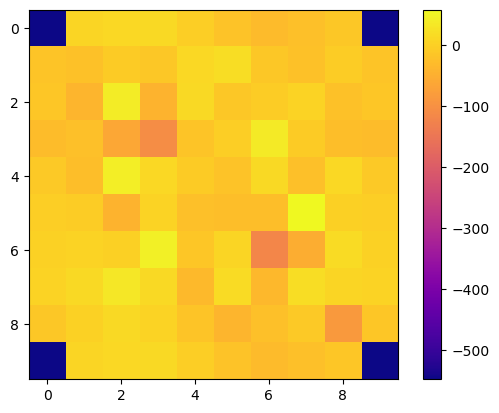

In [ ]:
plt.imshow(chern2_density[0, :, :, 0].real, cmap='plasma')
plt.colorbar()

In [ ]:
for mode in range(4):
    print("Mode ", mode)
    b_curv = berry_curvature(v[mode], H[mode], occ_idxs=range(n_occ))
    epsilon = levi_civita(4, 4)
    chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv, b_curv) * (1/(16*np.pi))
    chern2_density = chern2_density.reshape((nk, nk, nk, 2))
    dtheta = np.sum(chern2_density[:-1, :-1, :-1], axis=(0,1,2)) * d3k
    print(dtheta)

Mode  0
[-33.92484848+0.j   9.99498484+0.j]
Mode  1
[-115.33383824+0.j -761.77454627+0.j]
Mode  2
[-0.00030436 +0.j         nan+nanj]
Mode  3
[-0.00030436 +0.j         nan+nanj]


In [ ]:
# Integrate over k (excluding k_i=1)
dtheta

array([-33.92484848+0.j,   9.99498484+0.j])